In [1]:
from scipy import optimize
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("call_options.csv")
df.head()

,TradeDate,ExpiryDate,PutCall,Strikex1000,Strike,BidPrice,AskPrice,Volume,ImpliedVol,Delta,OpenInterest,Vega,Delete
0,18-Mar-2004,17-Apr-2004,0,700000,700,422.5,424.5,0,0.86843,0.98006,1,14.202,N
1,18-Mar-2004,17-Apr-2004,0,725000,725,397.5,399.5,0,0.81016,0.97897,0,14.908,N
2,18-Mar-2004,17-Apr-2004,0,750000,750,372.5,374.5,0,0.75372,0.97776,0,15.674,N
3,18-Mar-2004,17-Apr-2004,0,775000,775,347.5,349.5,0,0.69894,0.97643,0,16.513,N
4,18-Mar-2004,17-Apr-2004,0,800000,800,322.6,324.6,0,0.65134,0.97405,0,17.983,N


## Q1(c)

Using the implied volatility value from the option metrics file for your option as the volatility
input to the Black-Scholes model (including a dividend yield), price your option and
compare to the mid-point of the option metrics bid/ask spread.

In [3]:
def BSM( K, T, S0, r, y, sigma ):
    numerator = np.log(S0/K) + (r-y+0.5*sigma**2)*T
    denominator = sigma*np.sqrt(T)
    d1 = numerator/denominator;
    d2 = d1 - denominator;
    cprice = S0 *np.exp(-y*T)* norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2);
    delta = norm.cdf(d1);
    gamma = norm.pdf(d1) / (S0*denominator);
    return (cprice, delta, gamma)

In [4]:
S0 = 1122.319946;
K = df['Strike'];
T = 1/12;
r = 0.0110362;
y = 0.01632286;
sigma = df['ImpliedVol'];

In [5]:
cprice, delta, gamma = BSM(K, T, S0, r, y, sigma)
df['CallOptionsPrice'] = cprice
df['BidAskMid'] = (df.BidPrice + df.AskPrice)/2;

In [6]:
df.head()

,TradeDate,ExpiryDate,PutCall,Strikex1000,Strike,BidPrice,AskPrice,Volume,ImpliedVol,Delta,OpenInterest,Vega,Delete,CallOptionsPrice,BidAskMid
0,18-Mar-2004,17-Apr-2004,0,700000,700,422.5,424.5,0,0.86843,0.98006,1,14.202,N,423.997500,423.5
1,18-Mar-2004,17-Apr-2004,0,725000,725,397.5,399.5,0,0.81016,0.97897,0,14.908,N,398.987045,398.5
2,18-Mar-2004,17-Apr-2004,0,750000,750,372.5,374.5,0,0.75372,0.97776,0,15.674,N,373.976369,373.5
3,18-Mar-2004,17-Apr-2004,0,775000,775,347.5,349.5,0,0.69894,0.97643,0,16.513,N,348.965098,348.5
4,18-Mar-2004,17-Apr-2004,0,800000,800,322.6,324.6,0,0.65134,0.97405,0,17.983,N,324.073442,323.6


## Q1(d)
Can you find an implied volatility (using e.g. excel solver/fmincon in Matlab) for which the
B-S-M formula price matches the midpoint of the Option Metrics Bid/Ask spread exactly?

In [7]:
def calcimpliedvol(S0,K,T,r,y,midpointBA):
  
    def BSModel(sigma):
        numerator = np.log(S0/K) + (r-y+0.5*sigma**2)*T
        denominator = sigma*np.sqrt(T)
        d1 = numerator/denominator;
        d2 = d1 - denominator;
        cprice=S0 *np.exp(-y*T)* norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2);
        fx = midpointBA - cprice
        return fx

    return optimize.brentq(BSModel,0.01,1)

In [8]:
imp_vol = []
for index, row in df.iterrows():
    x = calcimpliedvol(S0=S0,K=row['Strike'],T=T, r=r, y=y, midpointBA=row['BidAskMid'])
    imp_vol.append(x)

df['ImpliedVol_New'] = imp_vol

df['Impl_Diff'] = df['ImpliedVol'] - df['ImpliedVol_New']

In [9]:
df[['ImpliedVol', 'ImpliedVol_New', 'Impl_Diff']].head()

,ImpliedVol,ImpliedVol_New,Impl_Diff
0,0.86843,0.837660,0.030770
1,0.81016,0.781422,0.028738
2,0.75372,0.726946,0.026774
3,0.69894,0.674086,0.024854
4,0.65134,0.628026,0.023314


In [10]:
df[['ImpliedVol', 'ImpliedVol_New', 'Impl_Diff']].sort_values(by='Impl_Diff')

,ImpliedVol,ImpliedVol_New,Impl_Diff
13,0.27986,0.334966,-0.055106
21,0.16595,0.176807,-0.010857
27,0.14807,0.150998,-0.002928
30,0.15659,0.156106,0.000484
32,0.18062,0.178008,0.002612
29,0.14497,0.139141,0.005829
28,0.14591,0.140057,0.005853
25,0.14841,0.142473,0.005937
26,0.14898,0.143013,0.005967
24,0.15568,0.149466,0.006214


In [11]:
df[df['ImpliedVol']==0.15659]

,TradeDate,ExpiryDate,PutCall,Strikex1000,Strike,BidPrice,AskPrice,Volume,ImpliedVol,Delta,OpenInterest,Vega,Delete,CallOptionsPrice,BidAskMid,ImpliedVol_New,Impl_Diff
30,18-Mar-2004,17-Apr-2004,0,1230000,1230,0.3,0.5,385,0.15659,0.022386,13374,16.553,N,0.408174,0.4,0.156106,0.000484


## Q1(e)

Does this match the implied volatility in the Option Metrics data?

---
##### The implied volatility via `brentq()` solver is similar to the implied volatility in the Option Metrics data

---

In [12]:
df[['ImpliedVol', 'ImpliedVol_New']].iloc[[30]]

,ImpliedVol,ImpliedVol_New
30,0.15659,0.156106


## Q2(a)

The sensitivity of the Black-Scholes option price to changes in volatility, σ (from σ =5% to
σ =80% in steps of 5%).

In [13]:
#Range of values from 5% - 80% in steps of 5%
x = np.arange(0.05, 0.85, 0.05)
x

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 ])

In [14]:
S0 = 1122.319946;
K = 1230;
T = 1/12;
r = 0.0110362;
y = 0.01632286;
sigma = 0.15659;
bsm_map = []
for i in x:
    res = BSM(K, T, S0, r, y, i)
    bsm_map.append(res[0]) #store BSM's cprice in a list
    
    
#convert list to array
arr = np.array(bsm_map)

In [15]:
# create a df with the IV sensitivity ranges and its relevant cprice
q2_df = pd.DataFrame({'IV':x, 'BSM Option Price':arr})

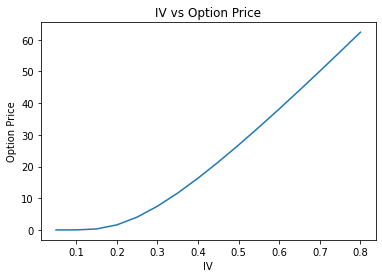

In [16]:
def plot_sensitivity(df, column1, column2):
    '''
    Function to produce resused graphs
    '''
    plt.plot(df[column1], df[column2])
    plt.xlabel(f"{column1}")
    plt.ylabel("Option Price")
    plt.title(f"{column1} vs Option Price")
    

plot_sensitivity(q2_df, "IV", 'BSM Option Price')

## Q2(c)

The sensitivity of the Black-Scholes option price to changes in the time to maturity T (T= 1
week, 1 month, 1 quarter, 6 months, 1 year, 5 years).

In [17]:
T_arr = np.array([1/52, 1/12, 3/12, 6/12, 1, 5])
bsm_T_list = []

for i in T_arr:
    res_2 = BSM(K, i, S0, r, y, sigma)
    print(res_2[0])
    bsm_T_list.append(res_2[0])


    
bsm_T_arr = np.array(bsm_T_list)

6.607968718835497e-05
0.4081735194878142
5.2789911755461105
14.163292490092147
29.635052850564307
96.45716479640453


In [18]:
bsm_T_arr

array([6.60796872e-05, 4.08173519e-01, 5.27899118e+00, 1.41632925e+01,
       2.96350529e+01, 9.64571648e+01])

In [19]:
T_arr.shape, bsm_T_arr.shape

((6,), (6,))

In [20]:
q2c_df = pd.DataFrame({'T':T_arr, 'BSM Option Price':bsm_T_arr})
q2c_df

,T,BSM Option Price
0,0.019231,0.000066
1,0.083333,0.408174
2,0.250000,5.278991
3,0.500000,14.163292
4,1.000000,29.635053
5,5.000000,96.457165


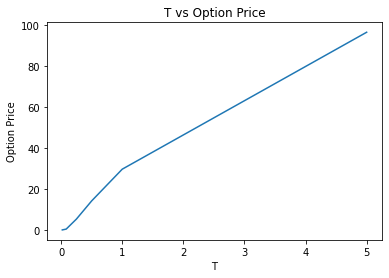

In [21]:
plot_sensitivity(q2c_df, "T", 'BSM Option Price')

## Q2(d)

The sensitivity of the Black-Scholes option price to changes in the interest rate r. (e.g. r in
the range 0% to 14%, in steps of 0.25%)

In [22]:
r_range = np.arange(0, 0.1425, 0.0025)

bsm_r_map = []
for i in r_range:
    res3 = BSM(K, T, S0, i, y, sigma)
    bsm_r_map.append(res3[0]) #store BSM's cprice in a list
    
    
#convert list to array
r_arr = np.array(bsm_r_map)

In [23]:
q2d_df = pd.DataFrame({'Rate':r_range, 'BSM Option Price':bsm_r_map})
q2d_df.head()

,Rate,BSM Option Price
0,0.0000,0.386394
1,0.0025,0.391235
2,0.0050,0.396130
3,0.0075,0.401079
4,0.0100,0.406083


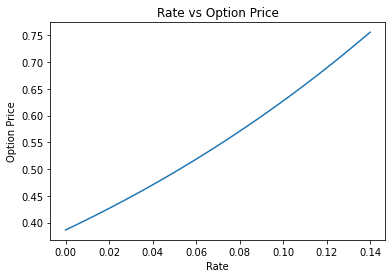

In [24]:
plot_sensitivity(q2d_df, 'Rate', 'BSM Option Price')